## Rare-event simulation

### Assignment 2

Due: Wednesday, March 24, 1:30 pm

Submission by email, send completed Jupyter notebook. 

Consider the portfolio loss incurred from defaults,

$$ L(\boldsymbol{X}) = c_1 1\{X_1 > x_1\} + \dots c_n 1\{X_n > x_n\} $$

where the $c_i$'s are the size of the outstanding loan to obliger $i$, and $1\{ X_i > x_i \}$ represents the random indicator for whether or not obliger $i$ will default on their loan. 

Here $X_i$ somewhat represents the level of financial strain for obliger $i$. This reflects the individual ("idiosyncratic") situation for each obliger, but all obligers are equally affected by broad economic swings. We model these separately, so

$$ X_i = \sqrt{(1-\rho)} \eta_i + \sqrt{\rho} Z $$

where $\rho \in (-1,1)$ specifies the $\mathbb{C}\mathrm{orr}(X_i,X_j)$, $Z \sim \mathsf{Normal}(0,1)$ are shared between all obligers, and $\eta_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Normal}(0, 1)$ is the idiosyncratic variable.

This problem is inspired by Section 5 of [Chan and Kroese (2011)](http://joshuachan.org/papers/impCE2.pdf), though I have simplified it a bit. This paper is extremely well written, I'd recommend taking a look for more explanation & context.

The main goal is to use crude Monte Carlo, cross-entropy method, and the improved cross-entropy method (with MCMC samples) to estimate

$$ \ell = \mathbb{P}(L(\boldsymbol{X}) > \gamma) \,.$$

We start by importing some packages and defining the constants for our particular problem.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy import stats
from tqdm.notebook import trange, tqdm
%config InlineBackend.figure_format = 'retina'

In [2]:
n = 10
ρ = 0.5
cs = np.exp(0.2 * np.arange(n))
xs = np.exp(0.2 * np.arange(n))
γ = 0.75 * np.sum(cs)
print("c:", list(cs))
print("x:", list(xs))
print("γ:", γ)

c: [1.0, 1.2214027581601699, 1.4918246976412703, 1.822118800390509, 2.225540928492468, 2.718281828459045, 3.320116922736548, 4.055199966844675, 4.953032424395115, 6.0496474644129465]
x: [1.0, 1.2214027581601699, 1.4918246976412703, 1.822118800390509, 2.225540928492468, 2.718281828459045, 3.320116922736548, 4.055199966844675, 4.953032424395115, 6.0496474644129465]
γ: 21.64287434364956


I'll supply the code for a (very) crude Monte Carlo run using a small number of $R$ replications. 

In [3]:
%%time 

rng = rnd.default_rng(1)
R = 10**6

ηs = rng.normal(size=(R, n))
Zs = rng.normal(size=(R, 1))
Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs

defaults = Xs > xs
losses = np.dot(defaults, cs)

ests = losses > γ

ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)
print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {np.maximum(ℓHat-widthCI, 0)}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")

CMC estimate:	 0.0 (+/- 0.0)
CMC low bound:	 0.0
CMC upp bound:	 0.0
Wall time: 379 ms


__Big crude Monte Carlo__

1) Run repeated crude Monte Carlo tests, as in the code demonstrations, so that in total you have a combined CMC test with $R=10^9$ iterations. 

In [4]:
%%time 

rng = rnd.default_rng(2)
R = 10**9
reps = 10**3

numExceed = 0
for _ in trange(reps):
    ηs = rng.normal(size=(R//reps, n))
    Zs = rng.normal(size=(R//reps, 1))
    Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs

    defaults = Xs > xs
    losses = np.dot(defaults, cs)

    numExceed += np.sum(losses > γ)

ℓHat = numExceed / R
σ2Hat = ((R-numExceed)*ℓHat**2 + numExceed*(ℓHat-1)**2)/R
widthCI = 1.96 * np.sqrt(σ2Hat) / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {np.maximum(ℓHat-widthCI, 0)}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")


CMC estimate:	 4e-09 (+/- 3.919999992160001e-09)
CMC low bound:	 8.000000783999937e-11
CMC upp bound:	 7.919999992160001e-09
Wall time: 9min 42s


__Improved cross-entropy method__

2) Use MCMC to sample $\boldsymbol{\eta} = (\eta_1, \dots, \eta_n)$ and $Z$ conditionally on the event that $L(\boldsymbol{X}) > \gamma$ where $\boldsymbol{X} \equiv \boldsymbol{X}(\boldsymbol{\eta}, Z)$. Use the random walk sampler where each jump is an $n+1$ dimensional vector of i.i.d. normal random variables. 

Note, if we say $\boldsymbol{X} \equiv \boldsymbol{X}(\boldsymbol{\eta}, Z)$, then the target density in terms of $\boldsymbol{\eta}$ and $Z$ is

$$ \pi(\boldsymbol{\eta}, Z) = \frac{1}{\ell} 1\bigl\{ L( \boldsymbol{X}(\boldsymbol{\eta}, Z) ) > \gamma \bigr\} \, \phi(Z) \prod_{i=1}^n \phi(\eta_i)   $$

where $\phi$ is the p.d.f. of a standard normal distribution. Since we don't need proportionality constants, we can instead use

$$ \pi(\eta, Z) = 1\bigl\{ L( \boldsymbol{X}(\boldsymbol{\eta}, Z) ) > \gamma \bigr\} \exp\Bigl\{ - \frac{Z^2}{2} \Bigr\} \prod_{i=1}^n \exp\Bigl\{ - \frac{\eta_i^2}{2} \Bigr\} \,.  $$

In [5]:
# Check the starting position of the chain is in
# the rare-event territory
η = 4*np.ones(n)
Z = 4 
Xs = np.sqrt(1-ρ) * η + np.sqrt(ρ) * Z

defaults = Xs > xs
print("Is the starting value valid?", np.dot(defaults, cs) > γ)

Is the starting value valid? True


In [6]:
def psi(x):
    return np.exp(-x**2 / 2)

def bankrupt(η, Z):
    X = np.sqrt(1-ρ) * η + np.sqrt(ρ) * Z
    defaults = (X > xs) 
    loss = np.dot(defaults, cs)
    return loss > γ 

def π(Y):
    η = Y[:-1]
    Z = Y[-1]
    if bankrupt(η, Z):
        return np.prod(psi(η)) * psi(Z)
    else:
        return 0

In [7]:
%%time 

rng = rnd.default_rng(3)
R = 10**6

X = np.ones((R, n+1))
X[0,:] = 4

jumps = rng.normal(size=(R-1, n+1), scale=1/3)
uniforms = rng.uniform(size=R-1)

for t in trange(1, R):
    Y = X[t-1,:] + jumps[t-1,:]
    α = π(Y) / π(X[t-1,:])
    
    if uniforms[t-1] < α:
        X[t,:] = Y
    else:
        X[t,:] = X[t-1,:]


Wall time: 1min 30s


An alternative solution using numba.

In [8]:
%%time 
from numba import njit

@njit()
def psi(x):
    return np.exp(-x**2 / 2)

@njit()
def bankrupt(η, Z):
    X = np.sqrt(1-ρ) * η + np.sqrt(ρ) * Z
    defaults = (X > xs) 
    loss = 0
    for i in range(len(cs)):
        if defaults[i]:
            loss += cs[i]
    return loss > γ 

@njit()
def π(Y):
    η = Y[:-1]
    Z = Y[-1]
    if bankrupt(η, Z):
        return np.prod(psi(η)) * psi(Z)
    else:
        return 0
    
@njit()
def update(X, jumps, uniforms):
    R = len(uniforms)+1
    
    for t in range(1, R):
        Y = X[t-1,:] + jumps[t-1,:]
        α = π(Y) / π(X[t-1,:])

        if uniforms[t-1] < α:
            X[t,:] = Y
        else:
            X[t,:] = X[t-1,:]
            
            
rng = rnd.default_rng(3)
R = 10**6

X = np.ones((R, n+1))
X[0,:] = 4

jumps = rng.normal(size=(R-1, n+1), scale=1/3)
uniforms = rng.uniform(size=R-1)

update(X, jumps, uniforms)


Wall time: 4.62 s


3) Print out the traceplots for $\eta_1$ and $Z$. Throw away some burn in samples if you decide it is necessary.

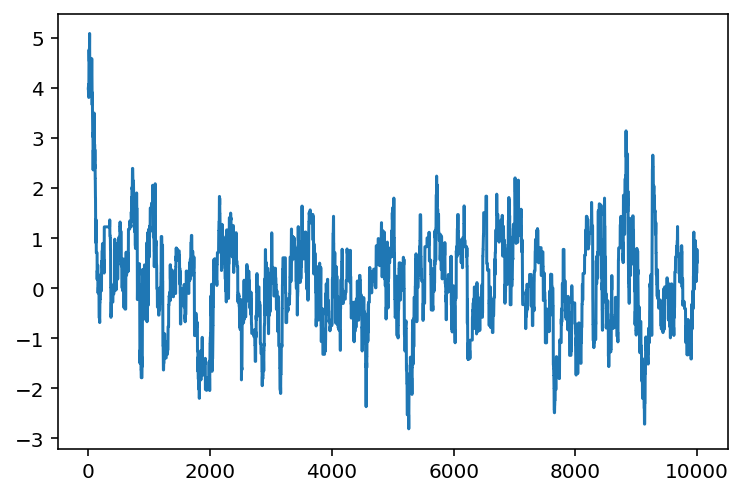

In [9]:
plt.plot(X[:10000,0]);

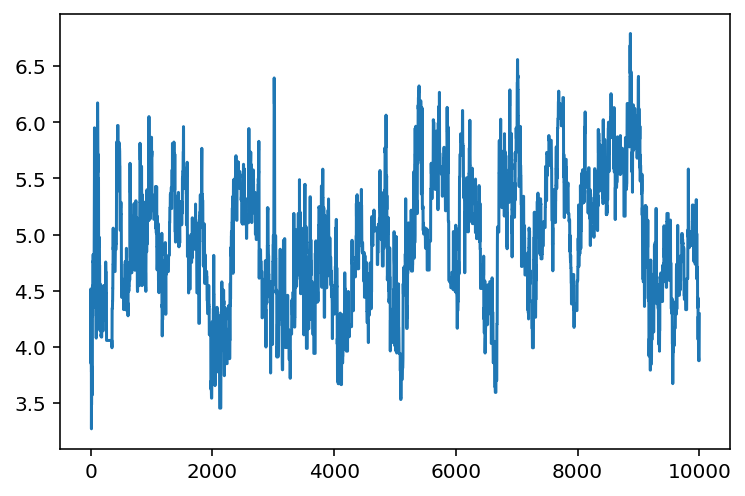

In [10]:
plt.plot(X[:10000,-1]);

In [11]:
# It's probably not necessary to throw away any samples
# though will remove the first 1000 just to demonstrate
# the process.
burnIn = 1000
X = X[burnIn:,]

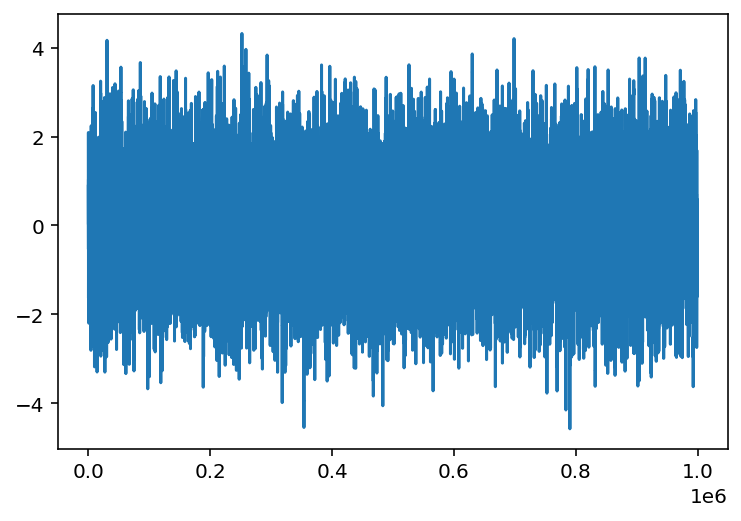

In [12]:
plt.plot(X[:,0]);

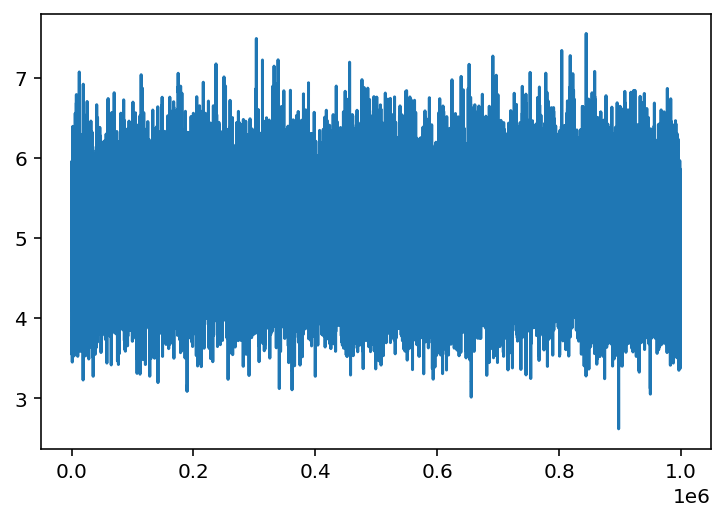

In [13]:
plt.plot(X[:,-1]);

4) Calculate the effective sample size (ESS) for your $Z$ samples and make sure that your $R$ is large enough so that this ESS is at least 1000. If it is too small, go back and update the previous cells until this constraint is reached. If this takes a long time, try playing with the scale parameter for the MCMC jumps. 

In [15]:
az.stats.ess(X[:,-1])

6669.302405919748

5) Use the arviz `plot_posterior` function to visualise the $\eta_0$ samples, again for the $\eta_n$ samples, and again for the $Z$ samples.

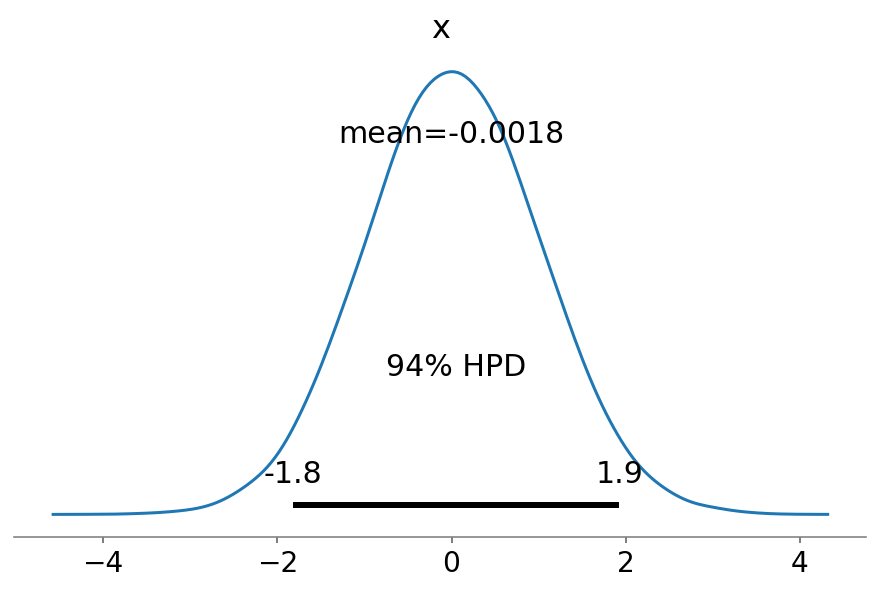

In [16]:
az.plot_posterior(X[:,0].reshape(-1));

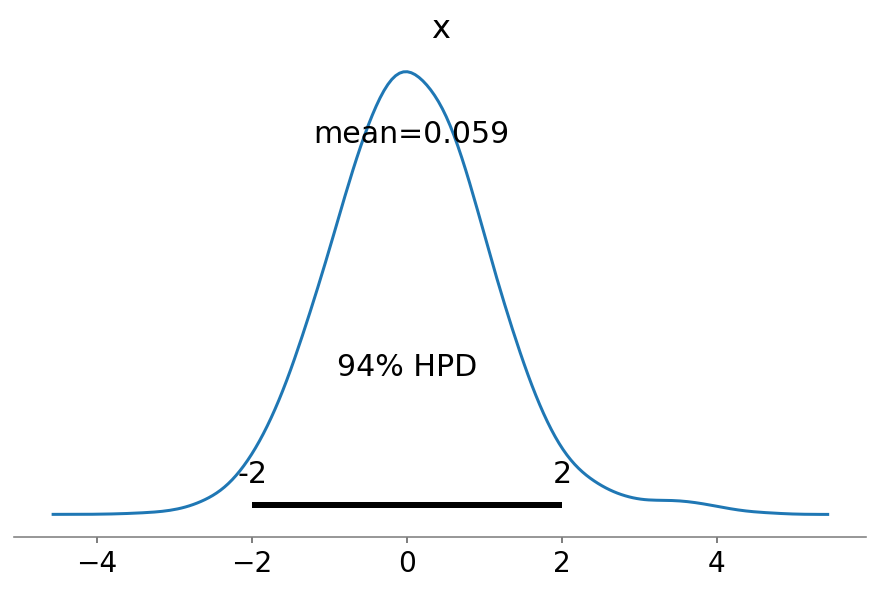

In [17]:
az.plot_posterior(X[:,-2].reshape(-1));

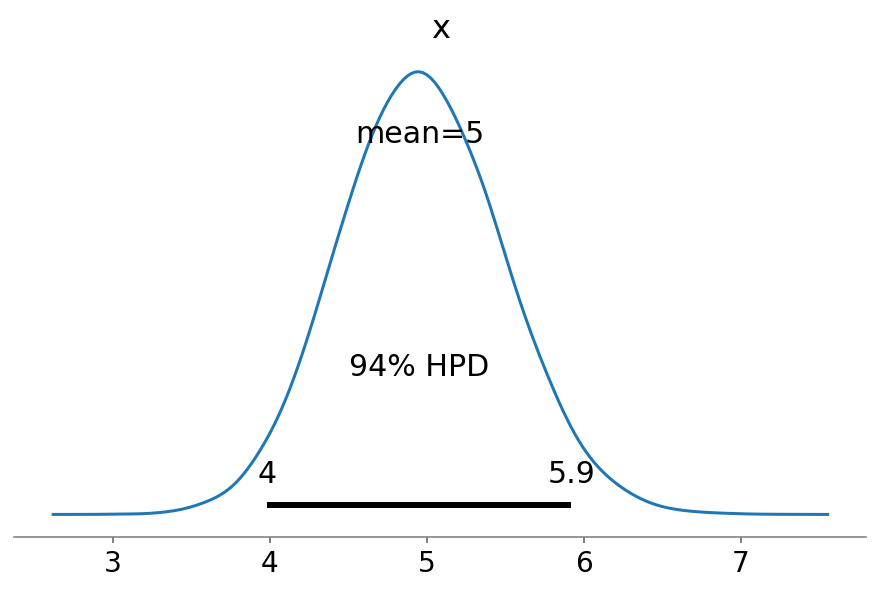

In [18]:
az.plot_posterior(X[:,-1]);

6) Calculate the overall sample mean $\overline{\eta}$ of the $\boldsymbol{\eta}$ samples (i.e. just one number for the mean of the $R \times n$ matrix of samples), and the sample mean $\overline{Z}$ of the $Z$ samples.

In [19]:
ηMean = X[:,:-1].mean()
ZMean = X[:,-1].mean()
ηMean, ZMean

(0.49581260929769416, 4.957173609599503)

7) Run importance sampling with $R=10^6$ samples where we sample each $\eta_i$ from a $\mathsf{Normal}(\overline{\eta}, 1)$ distribution and each $Z$ from a $\mathsf{Normal}(\overline{Z}, 1)$ distribution. This is the improved cross-entropy estimate. Print the result and the confidence interval. 

In [20]:
%%time 

R = 10**6

rng = rnd.default_rng(5)

ηs = rng.normal(loc=ηMean, size=(R, n))
Zs = rng.normal(loc=ZMean, size=(R, 1))
Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs

defaults = Xs > xs
losses = np.dot(defaults, cs)
ruin = losses > γ

LRs = np.zeros(R)
LRs[ruin] = np.prod(stats.norm.pdf(ηs[ruin,:]) \
                  / stats.norm.pdf(ηs[ruin,:], loc=ηMean), axis=1) \
            * stats.norm.pdf(Zs[ruin,:]).reshape(-1) \
            / stats.norm.pdf(Zs[ruin,:], loc=ZMean).reshape(-1)

ests = ruin * LRs

ℓHat = ests.mean()
σHat = ests.std()
widthCI = 1.96 * σHat / np.sqrt(R)

print(f"ICE estimate:\t {ℓHat} (+/- {widthCI})")
print(f"ICE low bound:\t {ℓHat-widthCI}")
print(f"ICE upp bound:\t {ℓHat+widthCI}")

ICE estimate:	 5.243910620567068e-09 (+/- 4.627129577163884e-10)
ICE low bound:	 4.781197662850679e-09
ICE upp bound:	 5.706623578283456e-09
Wall time: 1.06 s


__Cross entropy__

The problem above is particularly hard for the traditional CE method (probably why the authors chose it to compare their 'improved' version against it). Let's consider the same problem except the loss instead will be

$$ L(\boldsymbol{X}) = X_1 1\{X_1 > x_1\} + \dots X_n 1\{X_n > x_n\} \,.$$

Here are the constants we'll use for this question.

In [21]:
n = 3
ρ = 0.5
xs = np.exp(0.15 * np.arange(n))
γ = 1.5 * np.sum(xs)
print("x:", list(xs))
print("γ:", γ)

x: [1.0, 1.161834242728283, 1.3498588075760032]
γ: 5.267539575456429


8) Use the original cross-entropy algorithm to find a good proposal distribution. Look inside the family of distributions where $\eta_n \sim \mathsf{Normal}(\overline{\eta}_n, 1)$ (note, the other $\eta_i$'s are unchanged) and where $Z \sim \mathsf{Normal}(\overline{Z}, 1)$. 

In [22]:
%%time

R = 10**6
rng = rnd.default_rng(6)

maxIter = 20
ρCE = 0.05
v = (0, 0)

for iterNum in range(maxIter):
    print(v)
    ηShift = v[0]
    ZShift = v[1]
    
    ηs = rng.normal(size=(R,n))
    ηs[:,-1] += ηShift
    Zs = rng.normal(size=(R,1), loc=ZShift)
    Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs
    defaults = Xs > xs
    losses = np.sum(Xs * defaults, axis=1) 
    
    γ_i = np.quantile(losses, 1-ρCE)
    if γ_i >= γ:
        break
    
    isElite = losses > γ_i
    
    LRs = np.ones(R)
    LRs[isElite] *= stats.norm.pdf(ηs[isElite,-1]) \
                  / stats.norm.pdf(ηs[isElite,-1], loc=ηShift) \
                  * stats.norm.pdf(Zs[isElite]).reshape(-1) \
                  / stats.norm.pdf(Zs[isElite], loc=ZShift).reshape(-1) \
    
    ηShift = np.sum(isElite * LRs * ηs[:,-1].reshape(-1)) / np.sum(isElite * LRs)
    ZShift = np.sum(isElite * LRs * Zs.reshape(-1)) / np.sum(isElite * LRs)

    v = (ηShift, ZShift)

(0, 0)
(0.6059401516596912, 1.7511290515941598)
Wall time: 691 ms


9) Run importance sampling with this proposal to get the cross-entropy estimate.

In [23]:
%%time 
rng = rnd.default_rng(1234)
R = 10**6
ηShift = v[0]
ZShift = v[1]

ηs = rng.normal(size=(R,n))
ηs[:,-1] += ηShift
Zs = rng.normal(size=(R,1), loc=ZShift)

Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs
defaults = Xs > xs
losses = np.sum(Xs * defaults, axis=1)
ruin = losses > γ

LRs = np.ones(R)
LRs[ruin] *= stats.norm.pdf(ηs[ruin,-1]) \
           / stats.norm.pdf(ηs[ruin,-1], loc=ηShift) \
           * stats.norm.pdf(Zs[ruin]).reshape(-1) \
           / stats.norm.pdf(Zs[ruin], loc=ZShift).reshape(-1)

ests = LRs * ruin        
ℓHatCE = ests.mean()
σHatCE = ests.std()
widthCICE = 1.96 * σHatCE / np.sqrt(R)

print(f"CE estimate:\t {ℓHatCE} (+/- {widthCICE})")
print(f"CE low bound:\t {ℓHatCE-widthCICE}")
print(f"CE upp bound:\t {ℓHatCE+widthCICE}")

CMC estimate:	 0.01239800817976906 (+/- 6.480357683925041e-05)
CMC low bound:	 0.012333204602929809
CMC upp bound:	 0.01246281175660831
Wall time: 533 ms


Just running a big CMC on this new problem, so I can be confident the CE landed in the right place.

In [24]:
%%time 

rng = rnd.default_rng(112357)

R = 10**8
reps = 10**3

numExceed = 0
for _ in trange(reps):
    ηs = rng.normal(size=(R//reps, n))
    Zs = rng.normal(size=(R//reps, 1))
    Xs = np.sqrt(1-ρ) * ηs + np.sqrt(ρ) * Zs

    defaults = Xs > xs
    losses = np.sum(Xs * defaults, axis=1)
    numExceed += np.sum(losses > γ)

ℓHat = numExceed / R
σ2Hat = ((R-numExceed)*ℓHat**2 + numExceed*(ℓHat-1)**2)/R
widthCI = 1.96 * np.sqrt(σ2Hat) / np.sqrt(R)

print(f"CMC estimate:\t {ℓHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ℓHat-widthCI}")
print(f"CMC upp bound:\t {ℓHat+widthCI}")


CMC estimate:	 0.01236535 (+/- 2.1659949375610414e-05)
CMC low bound:	 0.012343690050624391
CMC upp bound:	 0.01238700994937561
Wall time: 21.5 s
